In [1]:
#Install libraries
#import Pkg; Pkg.add("JuMP")
#import Pkg; Pkg.add("Cbc")
#import Pkg; Pkg.add("Distances")
#import Pkg; Pkg.add("CairoMakie")

In [3]:
using JuMP, Cbc, Distances, Distributions, CairoMakie

- JuMP: domain-specific modeling language for mathematical optimization embedded in Julia.

- Distances: a Julia package for evaluating distances(metrics) between vectors.

- Distributions: package provides a large collection of probabilistic distributions and related functions.

- CairoMakie: data visualization

In [4]:
n_fac = 3
n_clients_1 = 4 #mercados
n_clients_2 = 4 #encuestados

4

In [5]:
coordinates = [
    -77.0125057 -12.1082707
    -77.0009741 -12.1135569
    -77.0235178 -12.1075984
    
    -77.025807 -12.118365
    -77.024108 -12.110307
    -77.010427 -12.108666
    -77.016581 -12.11665
    
    -77.0214718 -12.1187303
    -77.0176426 -12.1161587
    -77.0118733 -12.1126066
    -77.0101258 -12.1086169
   
];
#facilities, 1t, 2t

In [6]:
d = pairwise(Euclidean(), coordinates, dims=1);

In [175]:
#no se genera la diagonal
for i in 1:size(d)[1]
    d[i,i] = 9999999
end

In [176]:
#demanda (distribucion normal)
q = rand(Normal(30,5), size(d)[1]);
q[1:n_fac] .= 0;
#[0 0 1 1 1]

In [177]:
C = [500, 500, 500];
#capacidades de vehiculos

In [178]:
K = 1
#numero de vehiculos

1

In [152]:
function LRP(d, q, C)
    
    m = Model(Cbc.Optimizer)
    #si se activa el m
    @variable(m, y[i in 1:n_fac], Bin)
    @variable(m, x[i in 1:n_fac+n_clients_1, j in 1:n_fac+n_clients_1, k in 1:K], Bin)
    @variable(m, w[i in 1:n_fac+n_clients_2, j in 1:n_fac+n_clients_2, k in 1:K], Bin)
    
    @objective(m, Min, 
        sum(y) + 
        sum(d[i,j] * sum(x[i,j,k] for k in 1:K) for i in 1:n_fac+n_clients_1, j in 1:n_fac+n_clients_1)+
        sum(d[i,j] * sum(w[i,j,k] for k in 1:K) for i in 1:n_fac+n_clients_2, j in 1:n_fac+n_clients_2)
    )
    
    
    #Level 1 constraints
    #[] for
    @constraint(m, [i in 1:n_fac+n_clients_1, k in 1:K], sum(x[i,j,k] for j in 1:n_fac+n_clients_1) == 1)
    @constraint(m, [i in 1:n_fac, j in 1:n_fac, k in 1:K], x[i,j,k] == 0)
    @constraint(m, [i in 1:n_fac+n_clients_1, k in 1:K], 
        sum(x[i,j,k] for j in 1:n_fac+n_clients_1) - sum(x[j,i,k] for j in 1:n_fac+n_clients_1) == 0)
    @constraint(m, [i in n_fac+1:n_clients_1, k in 1:K], q[i] * sum(x[i,j,k] for j in 1:n_fac+n_clients_1) <= C[k])
    
    @constraint(m, [i in 1:n_fac, k in 1:K], 
        sum(x[i,1:n_fac+n_clients_1,k]) + sum(x[1:n_fac+n_clients_1,i,k]) - y[i] <= 1)
    
    #Level 2 constraints
    @constraint(m, [i in 1:n_fac+n_clients_2, k in 1:K], sum(w[i,j,k] for j in 1:n_fac+n_clients_2) == 1)
    @constraint(m, [i in 1:n_fac, j in 1:n_fac, k in 1:K], w[i,j,k] == 0)
    @constraint(m, [i in 1:n_fac+n_clients_2, k in 1:K], 
        sum(w[i,j,k] for j in 1:n_fac+n_clients_2) - sum(w[j,i,k] for j in 1:n_fac+n_clients_2) == 0)
    @constraint(m, [i in n_fac+1:n_clients_2, k in 1:K], q[i] * sum(w[i,j,k] for j in 1:n_fac+n_clients_2) <= C[k])
    
    @constraint(m, [i in 1:n_fac, k in 1:K], 
        sum(w[i,1:n_fac+n_clients_2,k]) + sum(w[1:n_fac+n_clients_2,i,k]) - y[i] <= 1)
    
    #optimizar 
    optimize!(m)
    #solver
    x_sol = JuMP.value.(x) #recupera toda la matriz x
    w_sol = JuMP.value.(w)
    y_sol = JuMP.value.(y)
    
    return x_sol, w_sol, y_sol
    
end

LRP (generic function with 1 method)

In [2]:
x_sol, w_sol, y_sol = LRP(d,q,C);

LoadError: UndefVarError: LRP not defined

In [180]:
#parejas de donde sales a donde vas
function selected_edges(x::Array{Float64}, n)
    return Tuple{Int,Int}[(j,i) for i in 1:n, j in 1:n if x[i, j] > 0.5]
end

selected_edges (generic function with 1 method)

In [181]:
#trazas reales de la matriz de distancia
function trace_route(edges, coordinates, tier)
    
    if tier == 1 
        x = hcat([coordinates[i,:] for (i,j) in edges]...)'
        y = hcat([coordinates[j,:] for (i,j) in edges]...)'
    else
        x = hcat([i <= n_fac ? coordinates[i,:] : coordinates[i+n_clients_1,:] for (i,j) in edges]...)'
        y = hcat([j <= n_fac ? coordinates[j,:] : coordinates[j+n_clients_1,:] for (i,j) in edges]...)'
    end
    
    x,y
end

trace_route (generic function with 1 method)

In [182]:
edges_1 = selected_edges(x_sol, size(x_sol, 1));
edges_2 = selected_edges(w_sol, size(w_sol, 1));

In [183]:
route_x_1, route_y_1 = trace_route(edges_1, coordinates, 1);
route_x_2, route_y_2 = trace_route(edges_2, coordinates, 2);

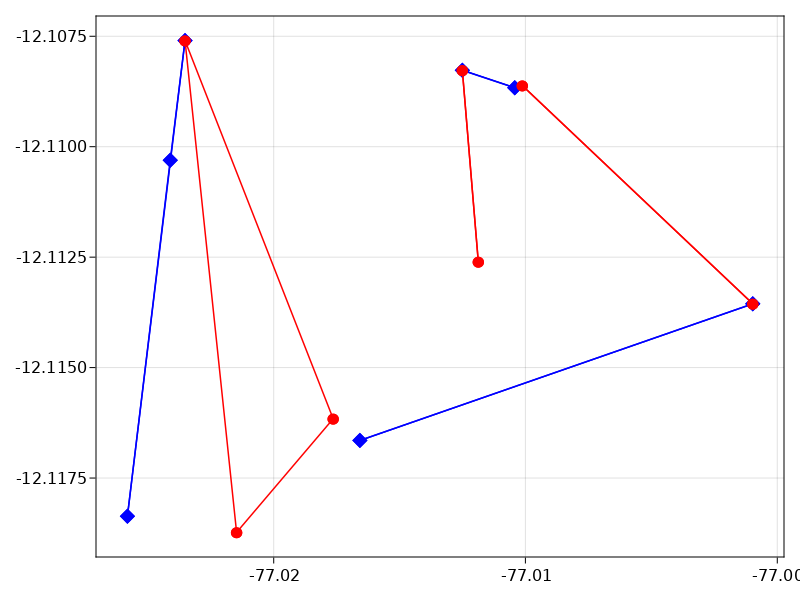

In [191]:
CairoMakie.scatter(coordinates)

for i in 1:n_fac+n_clients_1
    scatterlines!([route_x_1[i,1], route_y_1[i,1]], [route_x_1[i,2], route_y_1[i,2]], color = :blue, markersize=20, marker=:diamond)
end

for i in 1:n_fac+n_clients_2
    scatterlines!([route_x_2[i,1], route_y_2[i,1]], [route_x_2[i,2], route_y_2[i,2]], color = :red, markersize=15, marker=:circle)
end

current_figure()